# Degree group EDA

https://github.com/greenelab/connectivity-search-analyses/issues/176

In [1]:
import pandas as pd
import numpy as np
import plotnine as pn

from hetmatpy.hetmat import HetMat
from hetmatpy.degree_weight import dwpc
from hetmatpy.degree_group import dwpc_to_degrees
from hetmatpy.pipeline import add_gamma_hurdle_to_dgp_df

import sys
sys.path.append("..")
from src.database_utils import get_db_connection

In [3]:
# path = "../data/hetionet-v1.0.hetmat"
# use HetMat from local connectivity-search-backend which has downloaded all path counts
path = "../../connectivity-search-backend/dj_hetmech_app/management/commands/downloads/hetionet-v1.0.hetmat"
hm = HetMat(path)
hm

In [4]:
metapath = hm.metagraph.get_metapath("CbGpPWpG")
metapath

CbGpPWpG

In [5]:
# %%time
# row_ids, col_ids, dwpc_matrix = dwpc(hm, metapath, damping=0.5)
# dwpc_matrix

In [6]:
row_ids, col_ids, pc_matrix = hm.read_path_counts(metapath = metapath, metric="dwpc", damping=0.0)
row_ids, col_ids, dwpc_matrix = hm.read_path_counts(metapath = metapath, metric="dwpc", damping=0.5)

In [7]:
# density
pc_matrix.nnz / (len(row_ids) * len(col_ids))

0.13639481041411847

In [8]:
path = hm.get_running_degree_group_path(metapath, metric="dwpc", damping=0.5)
dgp_df = pd.read_table(path)
dgp_df["metapath"] = str(metapath)
dgp_df = add_gamma_hurdle_to_dgp_df(dgp_df)
# rename columns. See https://github.com/greenelab/connectivity-search-backend/blob/28d9626d75c5fa78b03ae0cb18b32f90bcf1fe8f/dj_hetmech_app/management/commands/populate_database.py#L254-L259
renamer = {
    "n": "n_null_dwpcs",
    "nnz": "n_null_dwpcs_nonzero",
    "mean_nz": "null_dwpc_nonzero_mean",
    "sd_nz": "null_dwpc_nonzero_sd",
    "beta": "null_dwpc_beta",
    "alpha": "null_dwpc_alpha",
}
dgp_df = dgp_df.rename(columns=renamer).drop(columns=["sum", "sum_of_squares"])
dgp_df.head(2)

,source_degree,target_degree,n_null_dwpcs,n_null_dwpcs_nonzero,n_perms,metapath,null_dwpc_nonzero_mean,null_dwpc_nonzero_sd,null_dwpc_beta,null_dwpc_alpha
0,0,0,390091600,0,200,CbGpPWpG,NaN,None,NaN,NaN
1,0,1,35110200,0,200,CbGpPWpG,NaN,None,NaN,NaN


In [9]:
%%time
rows = dwpc_to_degrees(hm, metapath)
dwpc_df = pd.DataFrame(rows)
dwpc_df.head()

CPU times: user 3min 5s, sys: 12.3 s, total: 3min 17s
Wall time: 3min 17s


,source_id,target_id,source_name,target_name,source_degree,target_degree,path_count,dwpc
0,DB00014,1,Goserelin,A1BG,2,0,0,0.000000
1,DB00014,2,Goserelin,A2M,2,16,2,0.975207
2,DB00014,9,Goserelin,NAT1,2,4,0,0.000000
3,DB00014,10,Goserelin,NAT2,2,6,0,0.000000
4,DB00014,12,Goserelin,SERPINA3,2,3,0,0.000000


In [10]:
%%time
def summarize(df: pd.DataFrame):
    return pd.Series({
        "n_dwpcs": len(df),
        "mean_dwpc": df.dwpc.mean(),
        "mean_pc": df.path_count.mean(),
        "dwpc_density": (df.path_count > 0).mean(),
    })

grouped_dwpc_df = (
    dwpc_df
    .groupby(["source_degree", "target_degree"])
    .apply(summarize)
    .reset_index()
)
grouped_dwpc_df.head(3)

CPU times: user 7.99 s, sys: 813 ms, total: 8.8 s
Wall time: 8.8 s


,source_degree,target_degree,n_dwpcs,mean_dwpc,mean_pc,dwpc_density
0,0,0,1950458.0,0.0,0.0,0.0
1,0,1,175551.0,0.0,0.0,0.0
2,0,2,160718.0,0.0,0.0,0.0


In [11]:
dg_df = (
    dgp_df
    .merge(grouped_dwpc_df)
    .eval("null_dwpc_density = n_null_dwpcs_nonzero / n_null_dwpcs")
    .eval("mean_null_dwpc = (null_dwpc_nonzero_mean * n_null_dwpcs_nonzero) / n_null_dwpcs")
)
dg_df["n_dwpcs_log10"] = np.log10(dg_df.n_dwpcs)
dg_df.head()

,source_degree,target_degree,n_null_dwpcs,n_null_dwpcs_nonzero,n_perms,metapath,null_dwpc_nonzero_mean,null_dwpc_nonzero_sd,null_dwpc_beta,null_dwpc_alpha,n_dwpcs,mean_dwpc,mean_pc,dwpc_density,null_dwpc_density,mean_null_dwpc,n_dwpcs_log10
0,0,0,390091600,0,200,CbGpPWpG,NaN,None,NaN,NaN,1950458.0,0.0,0.0,0.0,0.0,NaN,6.290137
1,0,1,35110200,0,200,CbGpPWpG,NaN,None,NaN,NaN,175551.0,0.0,0.0,0.0,0.0,NaN,5.244403
2,0,2,32143600,0,200,CbGpPWpG,NaN,None,NaN,NaN,160718.0,0.0,0.0,0.0,0.0,NaN,5.206065
3,0,3,23798000,0,200,CbGpPWpG,NaN,None,NaN,NaN,118990.0,0.0,0.0,0.0,0.0,NaN,5.075510
4,0,4,41402000,0,200,CbGpPWpG,NaN,None,NaN,NaN,207010.0,0.0,0.0,0.0,0.0,NaN,5.315991


In [12]:
x_lim = 0, 40
y_lim = 0, 20
range_df = dg_df[(dg_df.source_degree < y_lim[1]) & (dg_df.target_degree < x_lim[1])]

In [13]:
def plot_column(column: str, fill_trans="identity") -> pn.ggplot:
    return (
        pn.ggplot(dg_df, pn.aes('target_degree', 'source_degree', fill=column))
        + pn.geom_tile(na_rm=True)
        + pn.scale_fill_continuous(limits=(0, range_df[column].max()), trans=fill_trans) 
        + pn.coord_fixed(xlim=x_lim, ylim=y_lim, ratio=1)
        + pn.labs(x=f"Target {metapath.target()} Degree", y=f"Source {metapath.source()} Degree")
    )

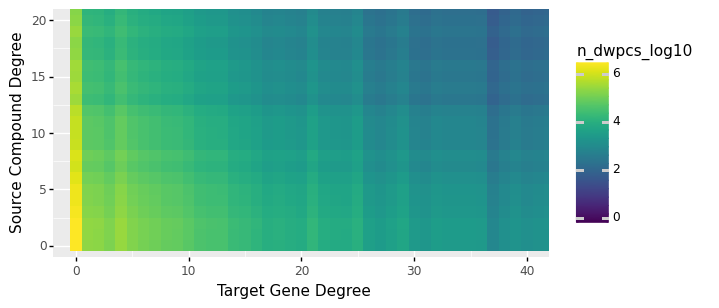

<ggplot: (8768319507658)>

In [14]:
plot_column("n_dwpcs_log10")

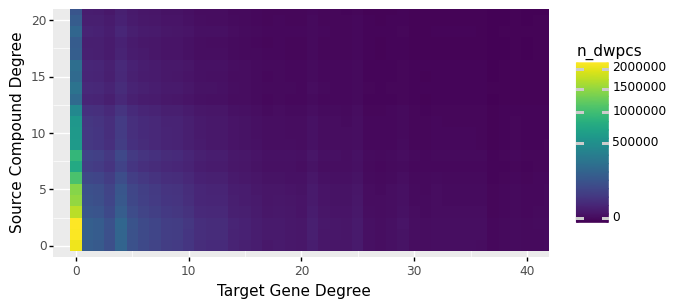

<ggplot: (8768319523789)>

In [15]:
plot_column("n_dwpcs", fill_trans="sqrt")

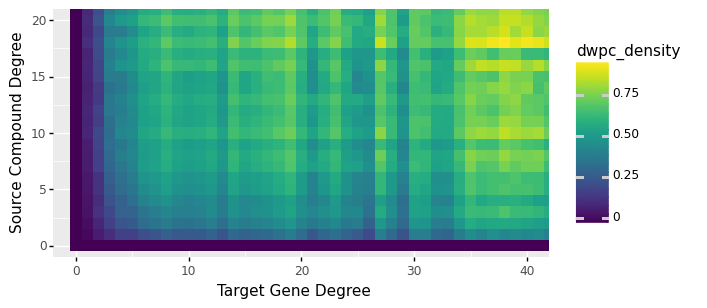

<ggplot: (8768318998116)>

In [16]:
plot_column("dwpc_density")

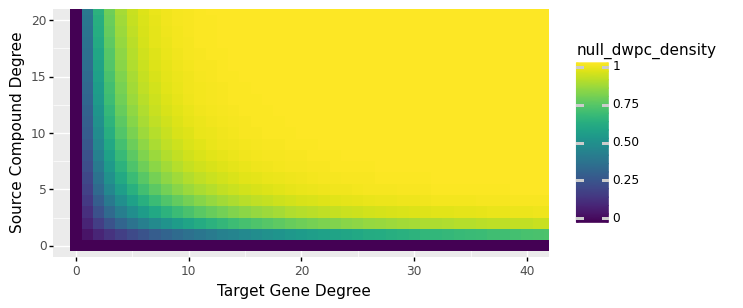

<ggplot: (8768318977823)>

In [17]:
plot_column("null_dwpc_density")

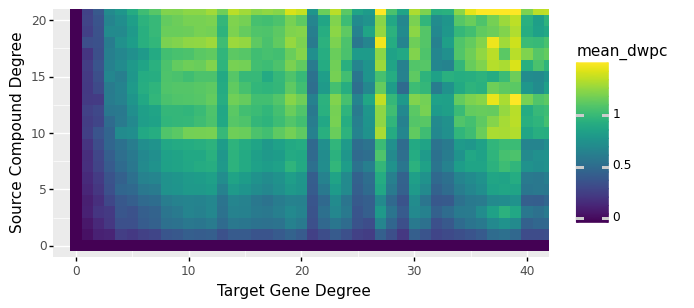

<ggplot: (8768319141738)>

In [18]:
plot_column("mean_dwpc")

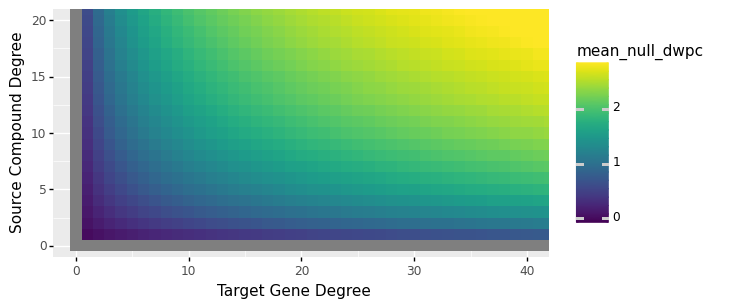

<ggplot: (8768319052876)>

In [19]:
plot_column("mean_null_dwpc")

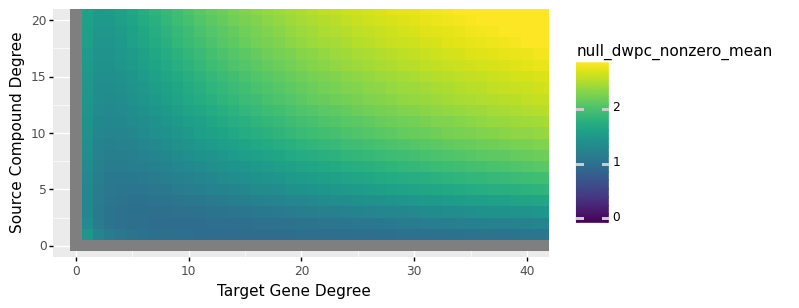

<ggplot: (8768317817052)>

In [20]:
plot_column("null_dwpc_nonzero_mean")

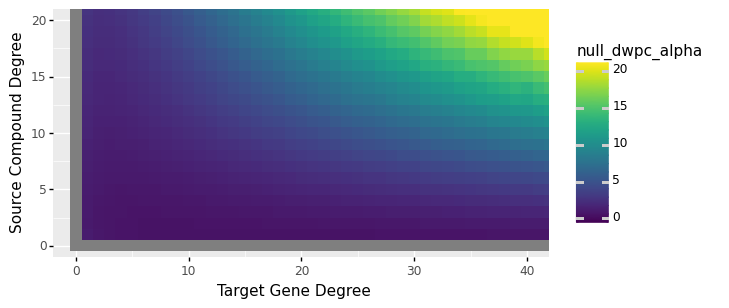

<ggplot: (8768318524459)>

In [21]:
dg_df.null_dwpc_alpha = dg_df.null_dwpc_alpha.astype(float)
plot_column("null_dwpc_alpha")

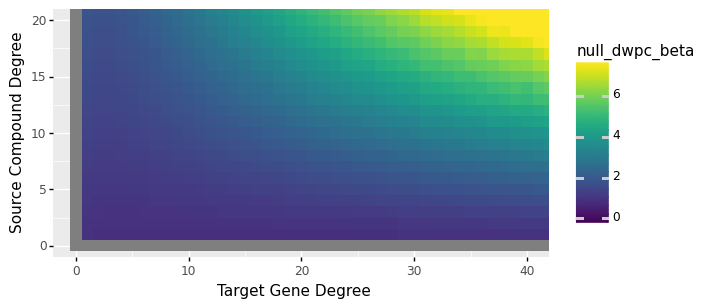

<ggplot: (8768316886899)>

In [22]:
dg_df.null_dwpc_beta = dg_df.null_dwpc_beta.astype(float)
plot_column("null_dwpc_beta")